# Project Work - Milestone 3
### Group 23

## Setup

In [ ]:
### Importing libraries ###

import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import torch.nn as nn
from torch import optim,nn
import torch.nn.functional as F
from operator import itemgetter
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch.nn.functional as F
from torchvision import transforms as T,models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import torchvision.models as models
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report


In [2]:
### Checking for Acceleration ###

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

## Data Loading and Pre-Processing

In [3]:
#### Data Reading ###

data = pd.read_csv('../input/sample/sample_labels.csv')

pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

for pathology in pathology_list :
    data[pathology] = data['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
    
data['No Findings'] = data['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

test = data

data = data.drop(list(data.iloc[:,1:11].columns.values),axis = 1)

In [4]:
### Init Dataset Class ###

class NIH_Dataset(Dataset):

    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir 
        self.transform = transform 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_file = self.img_dir + self.data.iloc[:,0][idx]
        img = Image.open(img_file).convert('RGB')
        label = np.array(self.data.iloc[:,1:].iloc[idx])

        if self.transform:
            img = self.transform(img)

        return img,label

In [5]:
### Image Transforms ###

data_transform = T.Compose([
    T.Resize((224,224)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


In [6]:
### Extract Data ###

trainds = NIH_Dataset(data,
                      img_dir = '../input/sample/sample/sample/images/',
                      transform = data_transform)

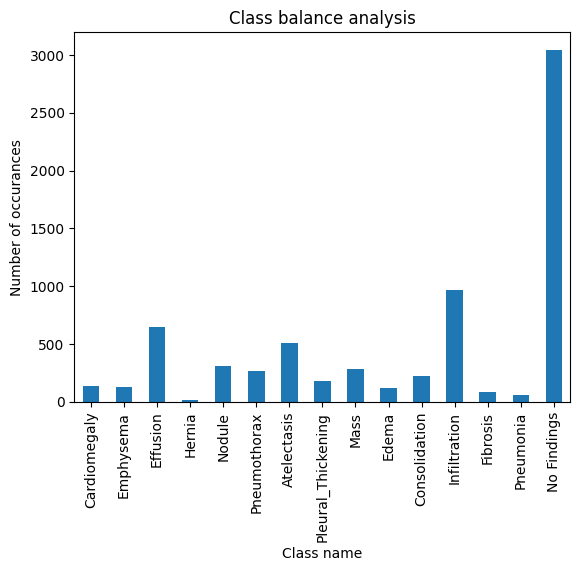

In [7]:
### Check data balance ###

np.sum(data)[1:].plot.bar()

plt.title("Class balance analysis")
plt.xlabel("Class name")
plt.ylabel("Number of occurances")
plt.show()

In [8]:
### Declare Data Sets ###

trainset, validset, testset = random_split(trainds, [5000,303,303])


In [ ]:
### Setup weighted loss ###

train_targets = []
for x in trainset:
    labels = x[1]
    idx = [i for i, e in enumerate(labels) if e == 1]
    for i in idx:
        train_targets.append(i)
len(train_targets)

from sklearn.utils.class_weight import compute_class_weight
# Pass a list of unique class labels for 'classes' and the list of all labels in the train set for 'y'
class_weights = compute_class_weight(class_weight="balanced", classes=list(set(train_targets)), y=train_targets)
# Convert the result to a float tensor to make it compatible with the loss function
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)

In [15]:
### Declare DataLoader ###

batch_size = 32

trainloader = DataLoader(trainset,
                         batch_size = batch_size,
                         shuffle = True)

validloader = DataLoader(validset,
                         batch_size = batch_size,
                         shuffle = True)

testloader = DataLoader(testset,
                        batch_size = batch_size,
                        shuffle = True)


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

## Define Training and Testing Functions

In [ ]:
### Training Function ###

def multi_train(model, train_loader, optimizer , criterion, epochs, val_loader):

    train_loss = []
    val_loss = []

    for epoch in range(epochs):

        running_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader):

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):

                # Predict
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                # Loss Calculation
                loss = criterion(outputs, labels.float())

                # Update gradients and Backprop
                loss.backward()
                optimizer.step()                

            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(train_loader)

        train_loss.append(avg_train_loss)
        
        running_loss_val = 0.0
    
        with torch.set_grad_enabled(False):
            for i, (inputs,labels) in enumerate(val_loader):

                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs,labels.float())

                running_loss_val += loss.item() * inputs.size(0)

        avg_val_loss = running_loss_val / len(val_loader)

        print("Epoch : {} Train Loss : {:.6f} Valdation Loss : {:.6f}".format(epoch+1,avg_train_loss,avg_val_loss))

    return


In [ ]:
### Test Function ###

def multi_test(model, criterion, test_loader):
    
    running_loss_test = 0.0
    test_total = 0

    for i, (inputs,labels) in enumerate(test_loader):

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs,labels)

        test_total += labels.size(0)
        running_loss_test += loss.item() * inputs.size(0)

    avg_test_loss = running_loss_test / test_total
    
    print("Test Loss : {:.6f}".format(avg_test_loss))

    return


## Network setup

In [100]:
### Load the ResNet model ###
resnet = models.resnet18(pretrained=True)

resnet.fc = nn.Linear(resnet.fc.in_features, 15)
resnet = resnet.to(device)


In [101]:
### Hyperparameters ###

epochs = 15
lr = 0.005

optimizer = torch.optim.Adam(resnet.parameters(), lr)
criterion = nn.CrossEntropyLoss()


## Training and Validation

In [102]:
### Training and Validation ### 
multi_train(resnet, trainloader, optimizer, criterion, epochs, validloader)

Epoch : 1 Train Loss : 85.292997 Valdation Loss : 76.917747
Epoch : 2 Train Loss : 78.735934 Valdation Loss : 77.855485
Epoch : 3 Train Loss : 77.288763 Valdation Loss : 77.550178
Epoch : 4 Train Loss : 76.744798 Valdation Loss : 76.984570
Epoch : 5 Train Loss : 76.710591 Valdation Loss : 76.487969
Epoch : 6 Train Loss : 76.364336 Valdation Loss : 74.745949
Epoch : 7 Train Loss : 75.681666 Valdation Loss : 74.221595
Epoch : 8 Train Loss : 75.376114 Valdation Loss : 76.274186
Epoch : 9 Train Loss : 76.911183 Valdation Loss : 73.831298
Epoch : 10 Train Loss : 74.957414 Valdation Loss : 73.788976
Epoch : 11 Train Loss : 74.211525 Valdation Loss : 72.981685
Epoch : 12 Train Loss : 74.163111 Valdation Loss : 73.279307
Epoch : 13 Train Loss : 73.892023 Valdation Loss : 73.072801
Epoch : 14 Train Loss : 73.405563 Valdation Loss : 72.064379
Epoch : 15 Train Loss : 73.097631 Valdation Loss : 71.769425


## Testing

In [ ]:
### Testing was done with the following accuracy functions ###

# multi_test(resnet, criterion, testloader)

## Accuracies and Confusion matrix

### Define Helper Functions

In [11]:
def class_accuracy(dataloader, model):

    per_class_accuracy = [0 for i in range(len(data.columns[1:]))]
    total = 0.0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for images,labels in dataloader:
            preds = model(images.to(device))
            labels = labels.to(device)
            preds = (preds >= 0.5).float()

            for i in range(preds.shape[1]):
                x1 = preds[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

            y_pred.append(preds.cpu().numpy().astype(int))
            y_true.append(labels.cpu().numpy())
            
        y_pred = np.concatenate(y_pred, axis=0)
        y_true = np.concatenate(y_true, axis=0)

        per_class_accuracy = [(i/len(dataloader.dataset))*100.0 for i in per_class_accuracy]

    return per_class_accuracy, y_pred, y_true


In [12]:
def get_acc_data(class_names,acc_list):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns =['Labels', 'Acc']) 
    return df


In [13]:
def compute_MLconfusion_matrix(y_true, y_pred):
    assert len(y_true) == len(
        y_pred), f"Not the same amount of predictions ({len(y_pred)}) as ground truth labels ({len(y_true)})"

    assert all(map(lambda x: len(x) == len(y_true[0]), y_true)) and all(
        map(lambda x: len(x) == len(y_true[0]), y_pred)), "The multi-labels must be of same length"

    num_classes = len(y_true[0])
    cm = np.zeros((num_classes, num_classes))

    for true_labels, pred_labels in zip(y_true, y_pred):
        # int conversion
        true_labels = [int(x) for x in true_labels] #int casting
        pred_labels = [int(y) for y in pred_labels]
        # label presnt in both ground truth and predictions
        right_preds = [k & l for k, l in zip(true_labels, pred_labels)]
        right_preds_indices = [i for i, x in enumerate(
            right_preds) if x == 1]  # their indices
        # label that are presetn in either ground truth or prediction
        diff_preds = [k - l for k, l in zip(true_labels, pred_labels)]
        # indices of ground truth label absent from prediction
        fn_indices = [i for i, x in enumerate(diff_preds) if x == 1]
        # indices of predictions that are not ground truth
        fp_indices = [i for i, x in enumerate(diff_preds) if x == -1]
        # for i in right_preds_indices: #perfect predictions
        #       conf[ 0, i, i] += 1
        if right_preds_indices == []:  # if pure confusion, do half the work
            for gt_idx in fn_indices:
                for p_idx in [i for i, x in enumerate(pred_labels) if x == 1]:
                    cm[gt_idx, p_idx] += 2  # score of 2 if pure cofusion
        else:
            for gt_idx in fn_indices:  # false negative : gt absent from preds
                for p_idx in [i for i, x in enumerate(pred_labels) if x == 1]:
                    cm[gt_idx, p_idx] += 1
            for p_idx in fp_indices:  # false positive : pred absent from gt
                for gt_idx in [i for i, x in enumerate(true_labels) if x == 1]:
                    cm[gt_idx, p_idx] += 1

    return cm


def plot_MLconfusion_matrix(cm, labels):
    """Quick plotting function for the multi-label confusion matrix

    Arguments:
        matrix {ndarray} -- multi-label 2D confusion matrix
        labels {list[str]} -- list of the labels. Should be in the right order.
    """
    g = sns.heatmap(cm, xticklabels=labels, yticklabels=labels)
    g.title.set_text("Confusion matrix of the test set")
    g.set_ylabel("Actual value")
    g.set_xlabel("Predicted value")
    plt.show()

### Get accuracies

In [107]:
### Get train accuracies ###
print("Train Dataset Accuracy Report")
acc_list, y_pred_train, y_true_train = class_accuracy(trainloader, resnet)
get_acc_data(pathology_list,acc_list)


Train Dataset Accuracy Report


,Labels,Acc
0,Cardiomegaly,97.56
1,Emphysema,97.88
2,Effusion,66.08
3,Hernia,99.78
4,Nodule,89.56
5,Pneumothorax,94.80
6,Atelectasis,67.72
7,Pleural_Thickening,96.96
8,Mass,93.78
9,Edema,96.32


In [17]:
### Get validation accuracies ###
print("Validation Dataset Accuracy Report")
acc_list, y_pred_val, y_true_val = class_accuracy(validloader, resnet)
get_acc_data(pathology_list,acc_list)

Validation Dataset Accuracy Report


,Labels,Acc
0,Cardiomegaly,98.679868
1,Emphysema,98.019802
2,Effusion,80.858086
3,Hernia,99.669967
4,Nodule,94.719472
5,Pneumothorax,92.739274
6,Atelectasis,87.458746
7,Pleural_Thickening,97.359736
8,Mass,95.049505
9,Edema,98.349835


In [109]:
### Get accuracies ###
print("Test Dataset Accuracy Report")
acc_list, y_pred_test, y_true_test = class_accuracy(testloader, resnet)
get_acc_data(pathology_list,acc_list)


Test Dataset Accuracy Report


,Labels,Acc
0,Cardiomegaly,97.029703
1,Emphysema,96.699670
2,Effusion,66.336634
3,Hernia,99.669967
4,Nodule,90.759076
5,Pneumothorax,94.389439
6,Atelectasis,70.297030
7,Pleural_Thickening,95.379538
8,Mass,93.399340
9,Edema,95.049505


### Classification reports

In [110]:
print(classification_report(y_true_train, y_pred_train,target_names=data.columns[1:]))

                    precision    recall  f1-score   support

      Cardiomegaly       0.00      0.00      0.00       122
         Emphysema       0.00      0.00      0.00       106
          Effusion       0.21      0.73      0.33       566
            Hernia       0.00      0.00      0.00        11
            Nodule       0.06      0.06      0.06       283
      Pneumothorax       0.16      0.02      0.04       239
       Atelectasis       0.15      0.57      0.24       452
Pleural_Thickening       0.00      0.00      0.00       152
              Mass       0.02      0.00      0.01       256
             Edema       0.10      0.10      0.10       102
     Consolidation       0.13      0.07      0.09       196
      Infiltration       0.18      0.97      0.30       859
          Fibrosis       0.08      0.04      0.05        76
         Pneumonia       0.00      0.00      0.00        56
       No Findings       0.55      1.00      0.71      2727

         micro avg       0.31      0.6

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
print(classification_report(y_true_val, y_pred_val,target_names=data.columns[1:]))

                    precision    recall  f1-score   support

      Cardiomegaly       0.00      0.00      0.00        10
         Emphysema       0.00      0.00      0.00        11
          Effusion       0.25      0.72      0.37        40
            Hernia       0.00      0.00      0.00         1
            Nodule       0.00      0.00      0.00        13
      Pneumothorax       0.00      0.00      0.00        15
       Atelectasis       0.18      0.53      0.27        34
Pleural_Thickening       0.00      0.00      0.00        10
              Mass       0.00      0.00      0.00        10
             Edema       0.40      0.50      0.44         8
     Consolidation       0.10      0.09      0.10        11
      Infiltration       0.18      0.98      0.30        54
          Fibrosis       0.00      0.00      0.00         3
         Pneumonia       0.00      0.00      0.00         3
       No Findings       0.53      1.00      0.70       161

         micro avg       0.31      0.6

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [112]:
print(classification_report(y_true_test, y_pred_test,target_names=data.columns[1:]))

                    precision    recall  f1-score   support

      Cardiomegaly       0.00      0.00      0.00         9
         Emphysema       0.00      0.00      0.00        10
          Effusion       0.21      0.63      0.32        38
            Hernia       0.00      0.00      0.00         1
            Nodule       0.13      0.12      0.12        17
      Pneumothorax       0.50      0.06      0.11        17
       Atelectasis       0.14      0.59      0.22        22
Pleural_Thickening       0.00      0.00      0.00        14
              Mass       0.00      0.00      0.00        18
             Edema       0.11      0.12      0.12         8
     Consolidation       0.22      0.11      0.14        19
      Infiltration       0.18      1.00      0.31        54
          Fibrosis       0.00      0.00      0.00         5
         Pneumonia       0.00      0.00      0.00         3
       No Findings       0.51      1.00      0.68       156

         micro avg       0.30      0.6

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion matrices

#### Per-class confusion matrices

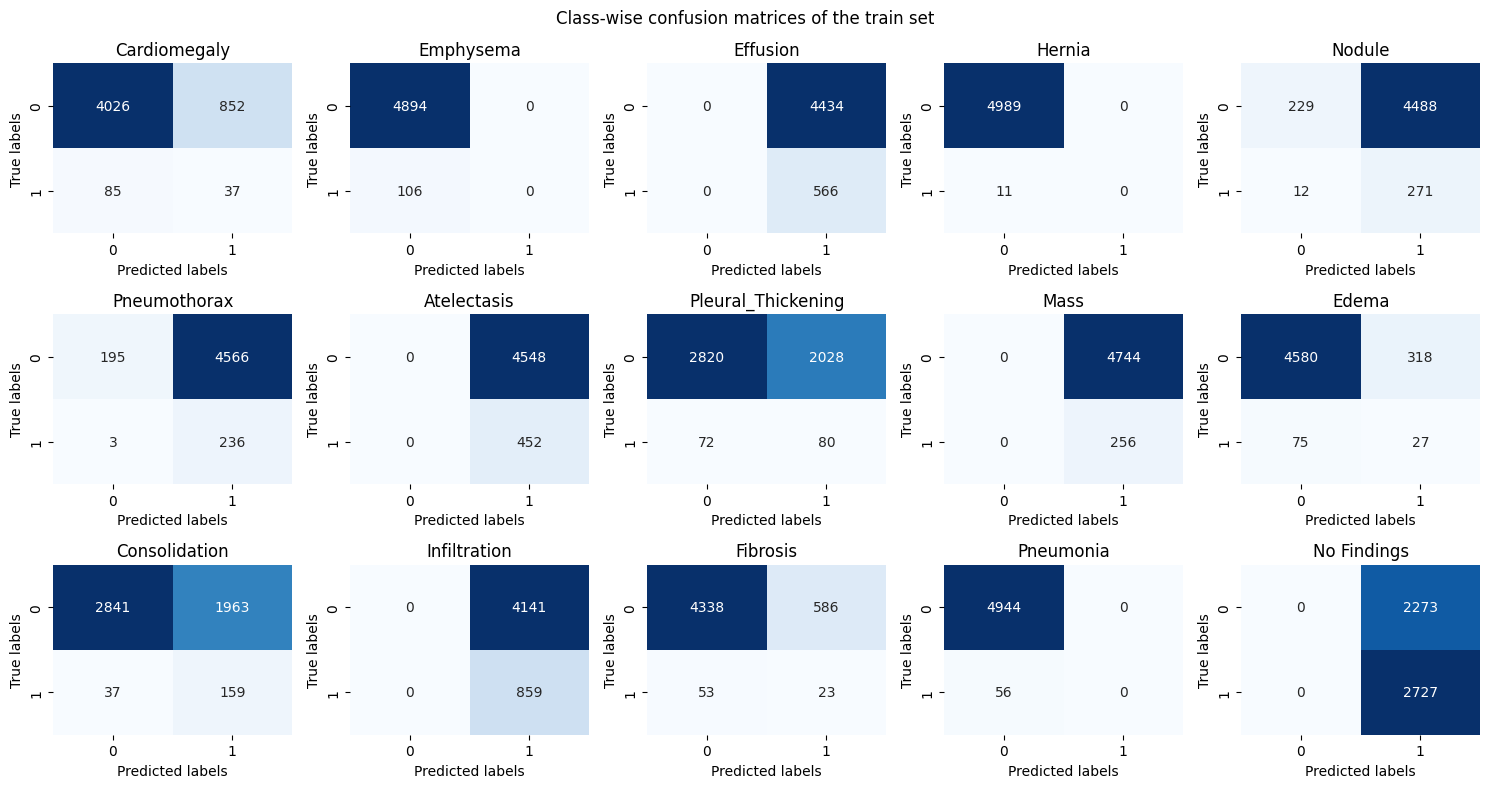

In [80]:
c_matrices = multilabel_confusion_matrix(y_true_train, y_pred_train)

cmap = plt.get_cmap('Blues')
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 8))

for cm, label, ax in zip(c_matrices, data.columns[1:], axes.flatten()):
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=cmap, cbar=False);

    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(f'{label}');
    
plt.suptitle("Class-wise confusion matrices of the train set")
plt.tight_layout()    
plt.show()

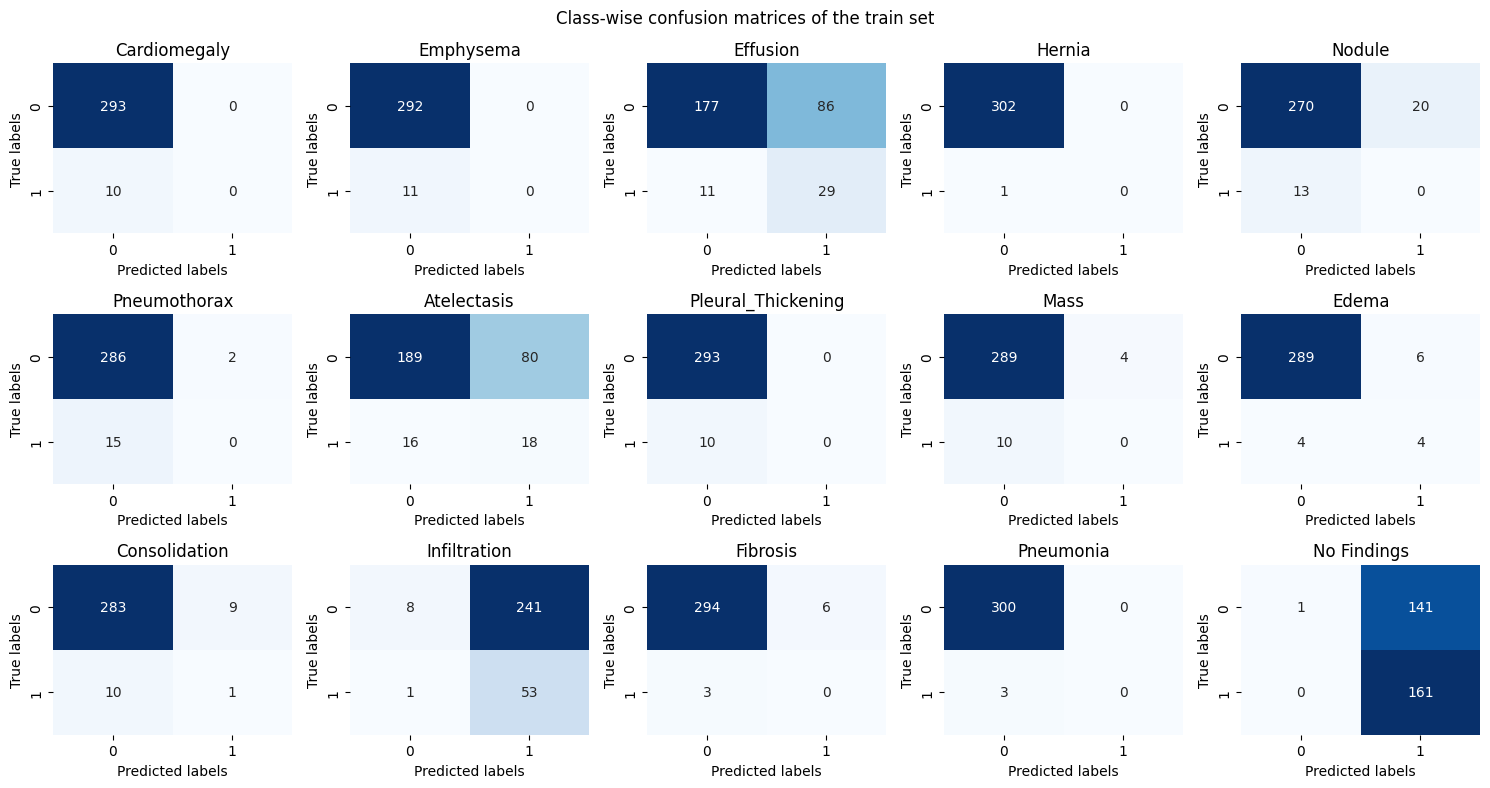

In [120]:
c_matrices = multilabel_confusion_matrix(y_true_val, y_pred_val)

cmap = plt.get_cmap('Blues')
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 8))

for cm, label, ax in zip(c_matrices, data.columns[1:], axes.flatten()):
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=cmap, cbar=False);

    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(f'{label}');

plt.suptitle("Class-wise confusion matrices of the train set")    
plt.tight_layout()    
plt.show()

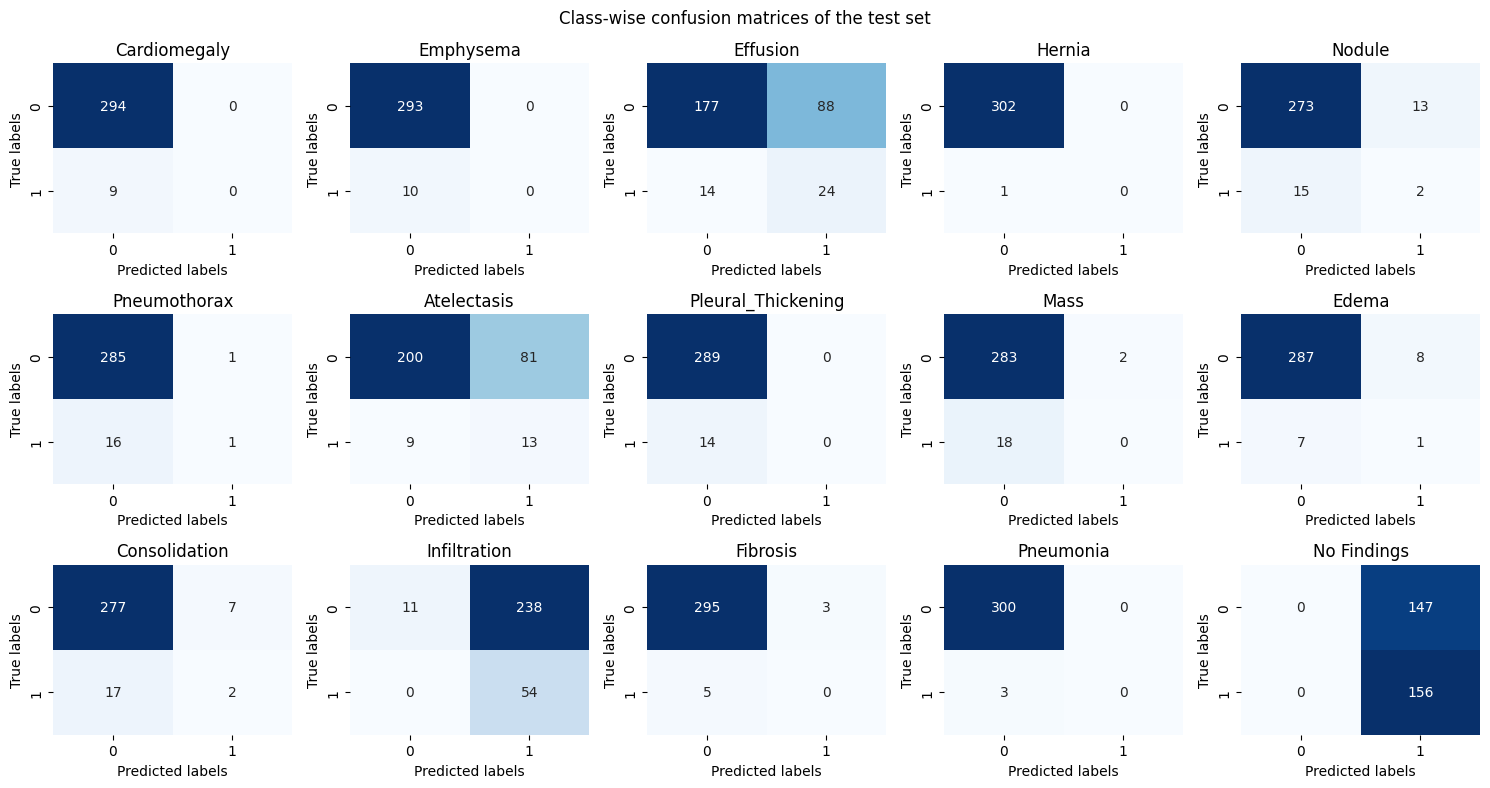

In [119]:
c_matrices = multilabel_confusion_matrix(y_true_test, y_pred_test)

cmap = plt.get_cmap('Blues')
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 8))

for cm, label, ax in zip(c_matrices, data.columns[1:], axes.flatten()):
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=cmap, cbar=False);

    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(f'{label}');

plt.suptitle("Class-wise confusion matrices of the test set")    
plt.tight_layout()    
plt.show()

#### Overall confusion matrices

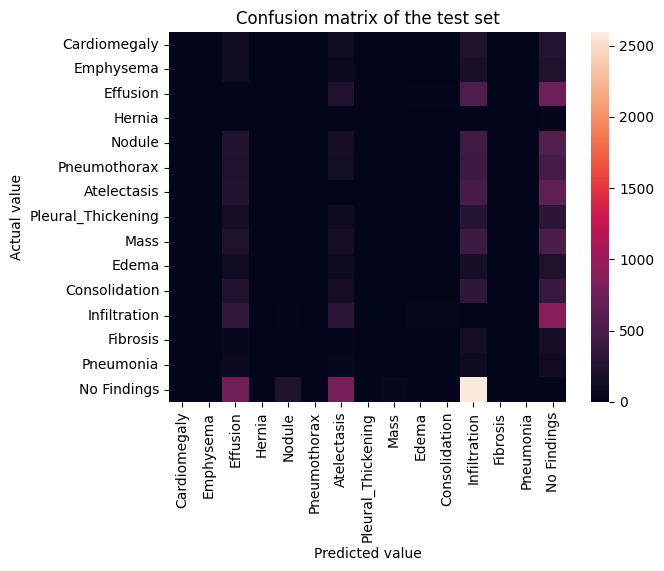

In [116]:
cm = compute_MLconfusion_matrix(y_true_train, y_pred_train)
plot_MLconfusion_matrix(cm, data.columns[1:])

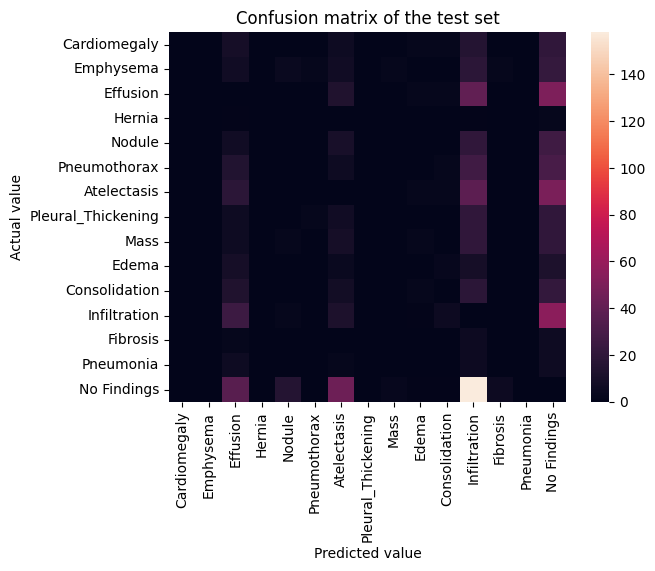

In [117]:
cm = compute_MLconfusion_matrix(y_true_val, y_pred_val)
plot_MLconfusion_matrix(cm, data.columns[1:])

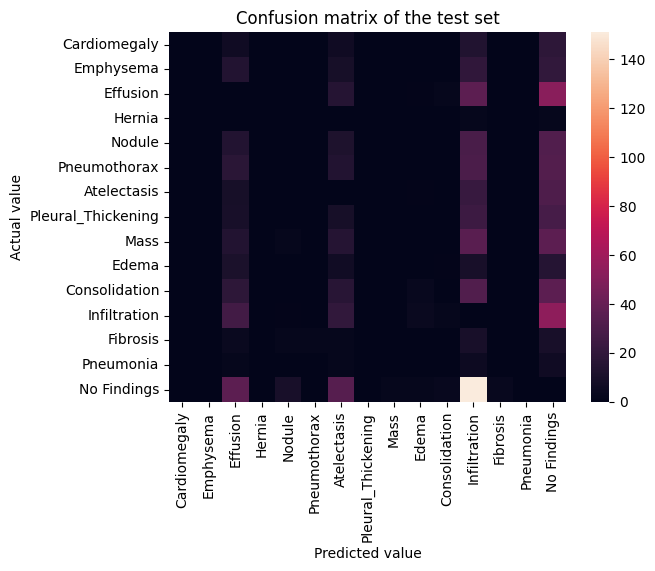

In [118]:
cm = compute_MLconfusion_matrix(y_true_test, y_pred_test)
plot_MLconfusion_matrix(cm, data.columns[1:])

In [103]:
### Save model ###
checkpoint = {'model': resnet,
          'state_dict': resnet.state_dict(),
          'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint-resnet18_15.pth')

In [10]:
### Load model ###

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    #model.eval()
    return model

resnet = load_checkpoint('/kaggle/input/checkpoint/checkpoint(1).pth')